In [1]:
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn

mms = MinMaxScaler()
# pca = PCA(n_components=8)

mnist = fetch_openml('mnist_784')
X_orig, y_orig = mnist["data"], mnist["target"]

X_orig = mms.fit_transform(np.array(X_orig).astype(np.float32))
y_orig = np.array(y_orig).astype(np.uint8)
target_digit1 = 3
target_digit2 = 8

target_digit1_xdata = X_orig[y_orig == target_digit1]
target_digit2_xdata = X_orig[y_orig == target_digit2]
target_digit1_ydata = y_orig[y_orig == target_digit1]
target_digit2_ydata = y_orig[y_orig == target_digit2]
X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)

y = np.where(y == target_digit1, -1, 1)

# reduce the dimensions of X
# X = pca.fit_transform(X)
# scale to 0/1
X = mms.fit_transform(X)

# # add on the bias
# X = np.concatenate([np.ones_like(X[:, :1]), X],axis=-1)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# pca.fit(X_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(8379, 784) (2793, 784) (2794, 784)
(8379,) (2793,) (2794,)


In [3]:
X_train = X_train
y_train = y_train

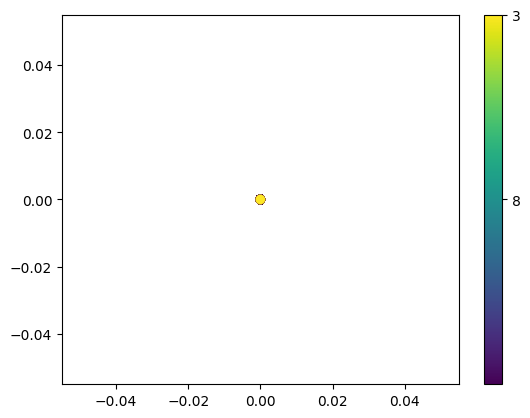

In [4]:
# pca2 = PCA(n_components=2)
# plotx = pca.fit_transform(X_train)

formatter = plt.FuncFormatter(lambda i, *args: np.where(y_train[i] == 1, target_digit2, target_digit1))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.colorbar(ticks=[0, 1], format=formatter)
# plt.xlabel(iris.feature_names[x_index])
# plt.ylabel(iris.feature_names[y_index])
plt.show()

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
device = 'cpu'
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).to(device)
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=1024)
test_dl = TensorDataset(X_test, y_test)
val_dl = TensorDataset(X_val, y_val)


In [6]:
class LinearSVM(nn.Module):
    def __init__(self, dim, C=1.0, bias=True):
        super().__init__()
        self.dim = dim
        self.w = nn.Parameter(torch.rand(self.dim))
        self.C = C
        self.b = nn.Parameter(torch.rand(1)) if bias else None

    def forward(self, X):                             # scores s = w^T x + b
        s = X @ self.w
        return s + self.b if self.b is not None else s

    def svm_loss(self, X, y, C=None, regularize_bias=False):
        C = C or self.C
        y = y.to(self.w.dtype)                          # y in {-1,+1}, float
        s = self(X)
        hinge = torch.clamp(1.0 - y * s, min=0.0)
        data_term = hinge.pow(2).mean()

        reg = 0.5 * (model.w @ model.w)

        if regularize_bias and (model.b is not None):
            reg = reg + 0.5 * (model.b * model.b)

        return reg + C * data_term

C = 1.0

lr = 1e-2
num_epochs = 10


dim = X_train.size(1)
model = LinearSVM(dim, C=1.0).to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2)

num_epochs = 2000
sb = tqdm(range(num_epochs))
tl = []

for epoch in sb:
    for Xb, yb in train_dl:
        loss = model.svm_loss(Xb, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = model.svm_loss(X_val, y_val)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])


100%|██████████| 2000/2000 [01:12<00:00, 27.70it/s, loss=0.324]


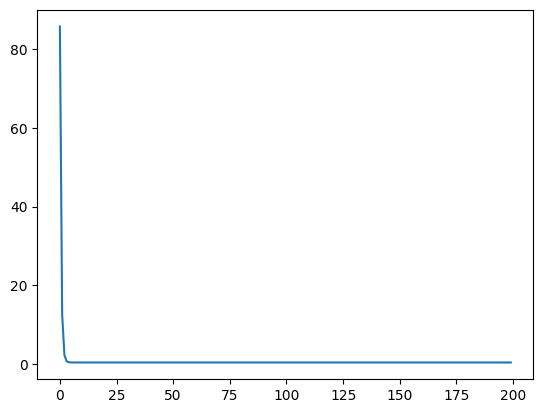

In [7]:
from matplotlib import pyplot as plt
tlnp = np.array(tl)
tlnp = tlnp
plt.plot(tlnp)
plt.show()

In [8]:
print(model.w, model.b)

Parameter containing:
tensor([ 7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,  7.0065e-44,
         7.0065e-44, -1.7459e

In [9]:
y_pred = (X_test @ model.w > 0) * 1.0


In [10]:
y_test_np = (y_test.detach().numpy() + 1.0)/2
y_pred_np = y_pred.detach().numpy()

In [11]:
from sklearn import metrics
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.9326888650196921
0.8857518056467498
0.9897285399853265


array([[1256,  174],
       [  14, 1349]])

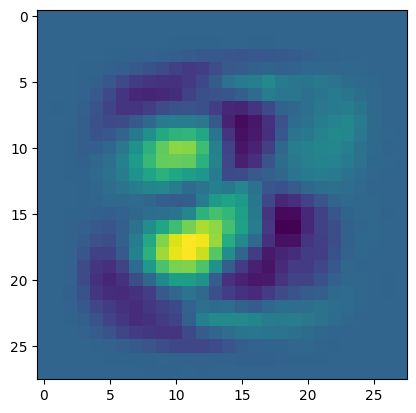

In [12]:
plt.imshow(model.w.detach().numpy().reshape((28,28)))

# Now to break it

In [13]:
for param in model.parameters():
    param.requires_grad = False


In [14]:
num_epochs = 1000
l2_reg = 0.5

perturbation = torch.rand(X_train.size(1)) * 0.001
perturbation.requires_grad = True

opt = torch.optim.SGD([perturbation], lr=1e-1)

Xb = X_train[:1, :]
yb = y_train[:1]
yb_pred_new = model(Xb).sign().detach().numpy()
yb_pred_new

sb = tqdm(range(num_epochs))
tl = []
for epoch in sb:
    new_Xb = torch.clamp(Xb + perturbation, 0.0, 1.0)
    new_yb = yb * -1
    loss = model.svm_loss(new_Xb, new_yb)

    l2_loss = perturbation.norm()
    total_loss = loss + l2_reg * l2_loss
    opt.zero_grad()
    total_loss.backward()
    opt.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            pred = model(new_Xb).sign().detach().numpy()
            # print(pred != yb_pred_new, np.sum(pred != yb_pred_new))
            # break
            if np.sum(pred != yb_pred_new) >= len(pred):
                print("Finished!")
                break
            loss = model.svm_loss(Xb + perturbation, yb)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])


  5%|▌         | 50/1000 [00:00<00:00, 2449.92it/s, loss=1.07]

Finished!


In [15]:
# y_pred = ((X_test + perturbation) @ model.w > 0) * 1.0
# y_test_np = (y_test.detach().numpy() + 1.0) / 2
# y_pred_np = y_pred.detach().numpy()
# from sklearn import metrics
#
# print(metrics.accuracy_score(y_test_np, y_pred_np))
# print(metrics.precision_score(y_test_np, y_pred_np))
# print(metrics.recall_score(y_test_np, y_pred_np))
# metrics.confusion_matrix(y_test_np, y_pred_np)

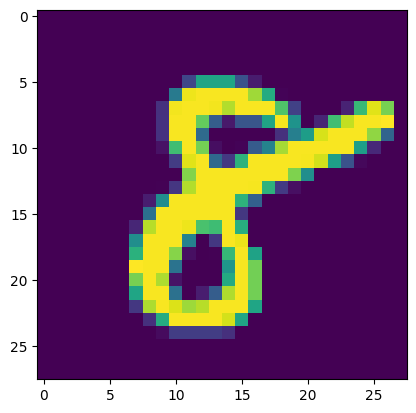

In [16]:
plt.imshow(Xb[:1].reshape((28,28)))

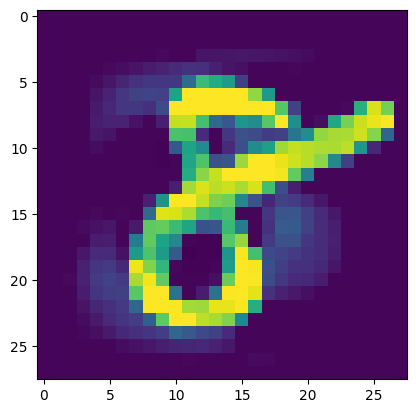

In [17]:
plt.imshow((Xb[:1] + perturbation.detach()).reshape((28,28)))

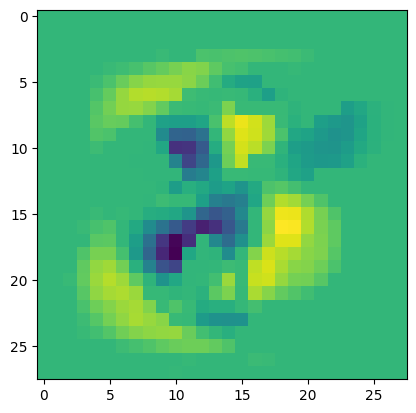

In [18]:
plt.imshow((perturbation.detach()).reshape((28,28)))

# Now to break CAL

# Now to break training


In [33]:
for param in model.parameters():
    param.requires_grad = True

C = 1.0

lr = 1e-2
num_epochs = 10

NUM_POISON_POINTS = 100

Xp = torch.rand((NUM_POISON_POINTS, X_train.size(1)))
yp = torch.Tensor([1] * (NUM_POISON_POINTS//2) + [-1] * (NUM_POISON_POINTS//2))
Xp.requires_grad = True


oldw = np.copy(model.w.detach().numpy())
oldb = np.copy(model.b.detach().numpy())
# dim = X_train.size(1)
# model = LinearSVM(dim, C=1.0).to(device)
optmodel = torch.optim.SGD(model.parameters(), lr=1e-4)
optpoison = torch.optim.SGD([Xp], lr=1e-1)

num_epochs = 500
sb = tqdm(range(num_epochs))
tl = []

for epoch in sb:
    Xb = torch.cat([X_train, Xp],dim=0)
    yb = torch.cat([y_train, yp], dim=0)

    # train the model stage
    loss = model.svm_loss(Xb, yb)
    optmodel.zero_grad()
    loss.backward()
    optmodel.step()

    # train the poison stage
    # new_Xb = torch.clamp(Xb, 0.0, 1.0)
    loss = -model.svm_loss(Xb, yb)
    optpoison.zero_grad()
    loss.backward()
    optpoison.step()
    with torch.no_grad():
        Xp = torch.clamp(Xp, 0.0, 1.0)

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = model.svm_loss(X_val, y_val)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])

neww = model.w.detach().numpy()
newb = model.b.detach().numpy()
print(neww - oldw)

100%|██████████| 500/500 [00:02<00:00, 172.27it/s, loss=0.323]

[-4.16868279e-05  4.42332748e-06 -4.04657912e-05 -1.33730064e-05
 -7.26606231e-06  8.88902105e-06  1.64149096e-05 -4.27795458e-05
 -1.33696740e-05  1.38467658e-06 -4.56342968e-06  1.24682892e-05
  1.38444302e-05 -3.12023849e-06  3.89931374e-05  8.93797551e-06
  4.96213761e-05 -1.08397217e-06  1.08508830e-05 -3.23262211e-05
 -1.86180932e-05 -1.53441142e-05 -2.92278128e-05 -2.66719435e-05
 -1.41900591e-05 -4.80965100e-05  2.14744068e-06  1.81049527e-05
 -3.73163784e-05  4.48439096e-06 -4.31298395e-06  1.00063335e-05
 -1.14215072e-06 -8.27599506e-05 -9.79057222e-06 -1.23997916e-06
  3.32828495e-06 -1.76671019e-05  1.48961699e-05  6.57064957e-05
  5.52639176e-05 -3.84399318e-05  2.61337846e-06  1.85758399e-05
 -3.93016671e-05  2.52220198e-05 -4.39053110e-06  2.15528416e-05
 -1.53825313e-05 -2.73757032e-05 -5.53559730e-05 -6.38100319e-05
 -1.24554645e-05  5.79426560e-05 -3.87156069e-05  3.70728085e-05
  3.01110049e-05 -1.09267596e-04  1.54998997e-05 -4.42716264e-05
 -8.02513387e-06 -2.84703

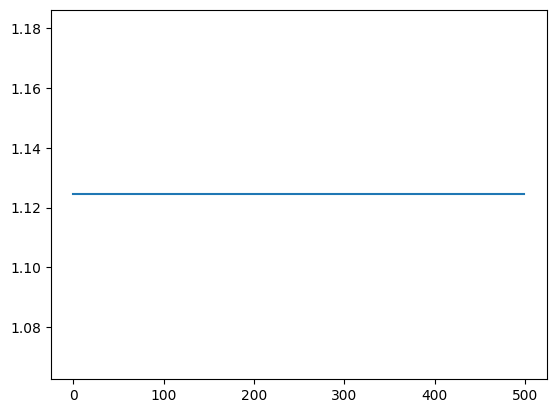

In [32]:
tlnp = np.array(tl)
# tlnpdiff = tlnp[1:] - tlnp[:-1]
plt.plot(tlnp)

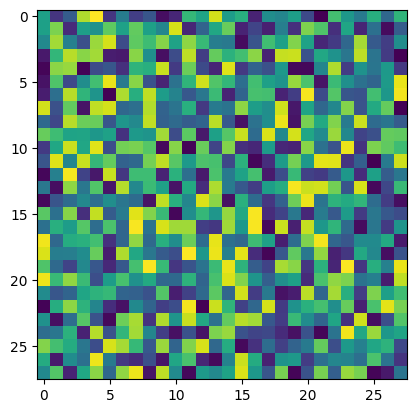

In [31]:
plt.imshow(Xp[1:2].detach().numpy().reshape((28,28)))

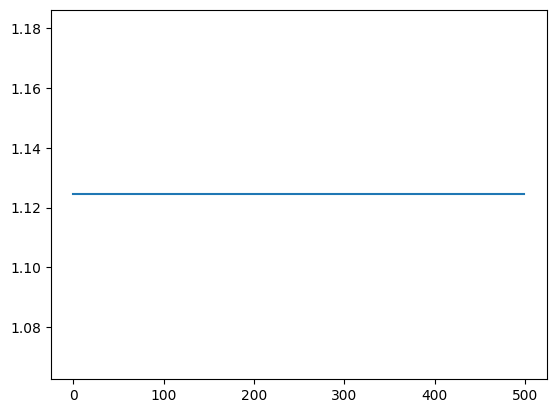

In [22]:
plt.plot(tl)

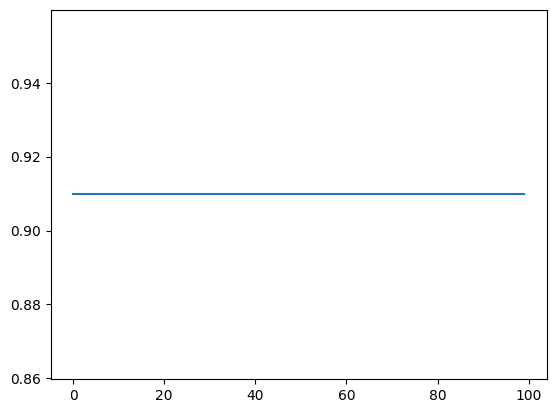